In [6]:
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import os

load_dotenv()

allen_cache_path = os.environ.get('HGMS_ALLEN_CACHE_PATH')
boc = BrainObservatoryCache(manifest_file=str(Path(allen_cache_path) / Path('brain_observatory_manifest.json')))

cell_exp = boc.get_ophys_experiments(experiment_container_ids=[511511001])

import pickle
file_path = "/home/maria/Documents/HuggingMouseData/TransformerEmbeddings/google_vit-base-patch16-224-in21k_embeddings.pkl"

with open(file_path, 'rb') as file:
    transfr = pickle.load(file)

movie_one=transfr['natural_movie_one']

data_set_regression = boc.get_ophys_experiment_data(506278598)
data_set_events= boc.get_ophys_experiment_events(506278598)
cells = data_set_regression.get_cell_specimen_ids()
cell2ix={cell:ix for ix, cell in enumerate(cells)}
ix2cell={ix:cell for ix, cell in enumerate(cells)}
stim_table=data_set_regression.get_stimulus_table('natural_movie_one')

ts=stim_table[stim_table['repeat'] == 0]['start']

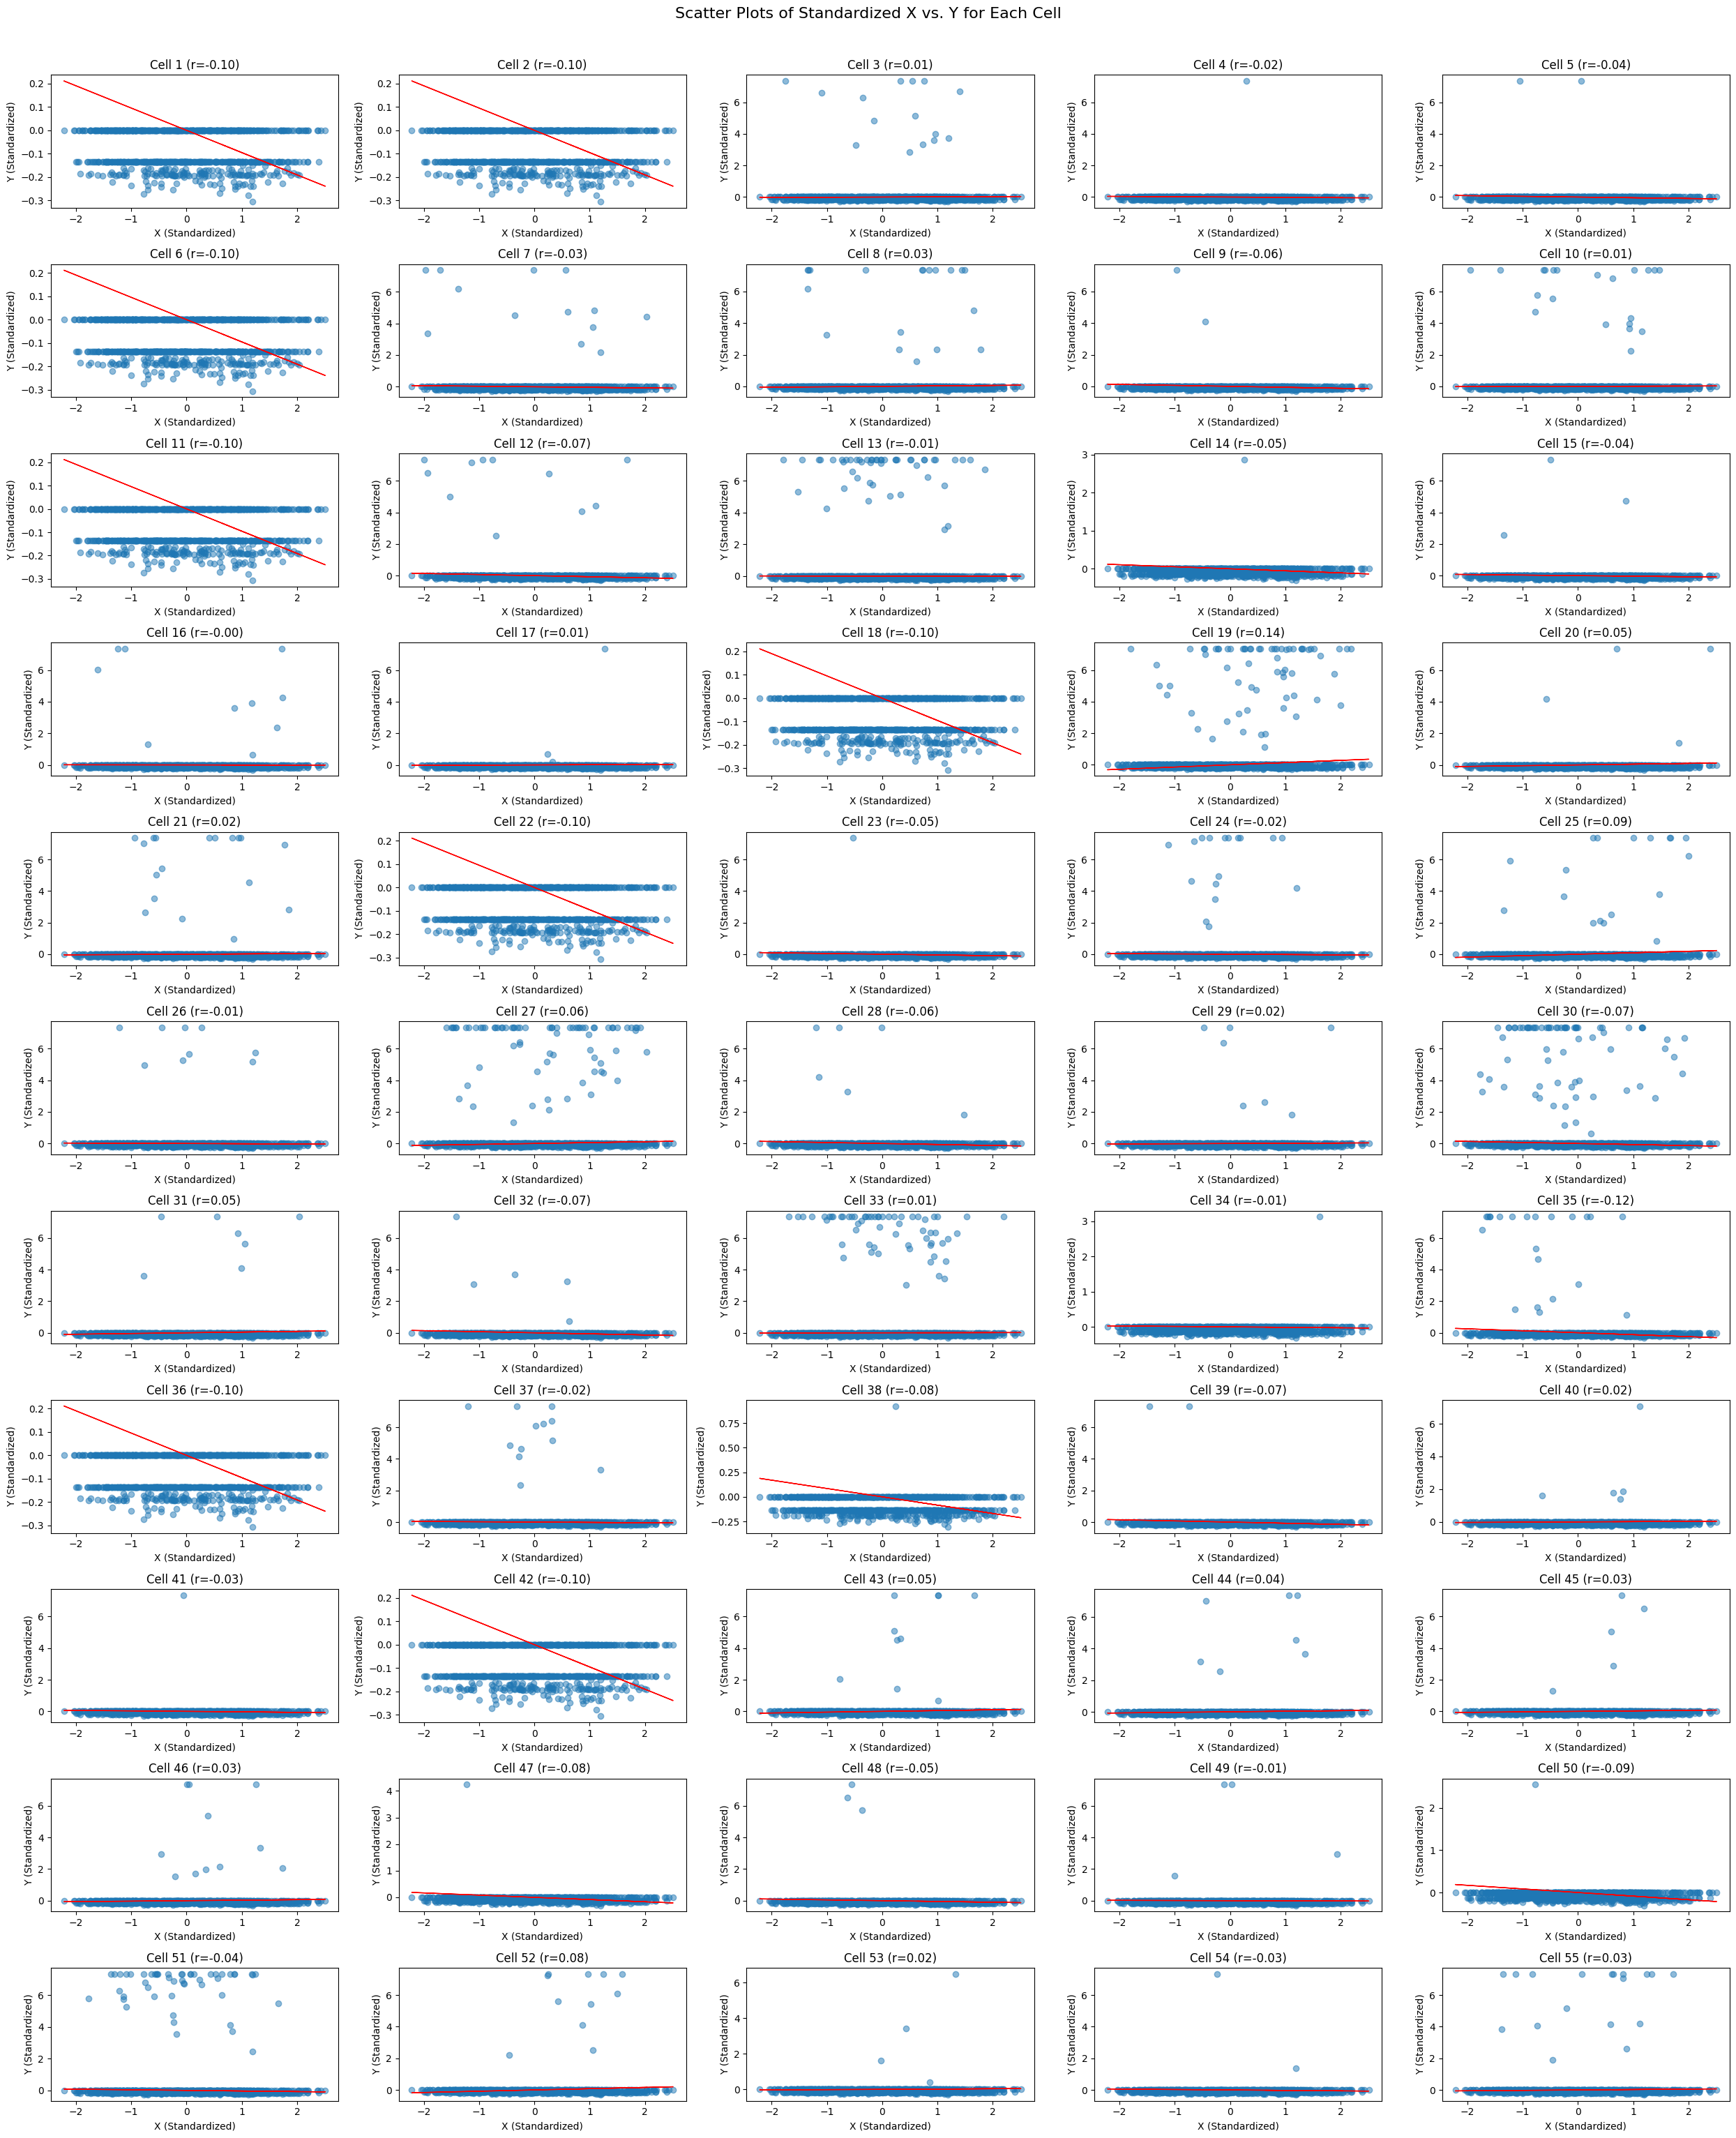

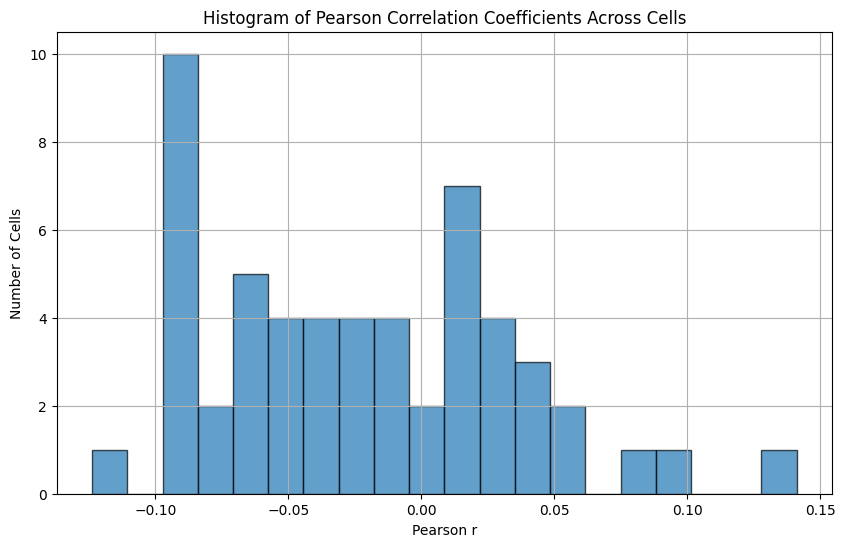

In [4]:
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import os
import pickle
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

# Load environment variables
load_dotenv()

# Initialize Brain Observatory Cache
allen_cache_path = os.environ.get('HGMS_ALLEN_CACHE_PATH')
manifest_file = str(Path(allen_cache_path) / Path('brain_observatory_manifest.json'))
boc = BrainObservatoryCache(manifest_file=manifest_file)

# Retrieve experiment container
cell_exp = boc.get_ophys_experiments(experiment_container_ids=[511511001])

# Load transformer embeddings
file_path = "/home/maria/Documents/HuggingMouseData/TransformerEmbeddings/google_vit-base-patch16-224-in21k_embeddings.pkl"

with open(file_path, 'rb') as file:
    transfr = pickle.load(file)

movie_one = transfr['natural_movie_one']  # Assuming shape (n_images, embedding_dim)

# Retrieve specific experiment data
experiment_id = 506278598
data_set_regression = boc.get_ophys_experiment_data(experiment_id)
data_set_events = boc.get_ophys_experiment_events(experiment_id)

# Get cell specimen IDs and mappings
cells = data_set_regression.get_cell_specimen_ids()
cell2ix = {cell: ix for ix, cell in enumerate(cells)}
ix2cell = {ix: cell for ix, cell in enumerate(cells)}

# Get stimulus table for 'natural_movie_one'
stim_table = data_set_regression.get_stimulus_table('natural_movie_one')

# Extract start times of stimuli (assuming 'repeat' == 0 refers to unique presentations)
ts = stim_table[stim_table['repeat'] == 0]['start'].values  # Shape: (n_stimuli,)

# Extract neural data
dff_traces =  boc.get_ophys_experiment_events(506278598)  # Shape: (n_cells, n_timepoints)

# Extract stimulus duration and sampling rate to align embeddings with neural data
#stim_duration = stim_table['duration'].iloc[0]  # Duration of each stimulus in seconds
#frame_rate = data_set_regression.get_sampling_rate()  # Frames per second

# Calculate number of timepoints per stimulus
timepoints_per_stim = 1

# Ensure that the number of embeddings matches the number of stimuli
n_stimuli = len(ts)
n_embeddings = movie_one.shape[0]

if n_stimuli != n_embeddings:
    raise ValueError(f"Number of stimuli ({n_stimuli}) does not match number of embeddings ({n_embeddings}). Please check data alignment.")

# Aggregate neural data per stimulus by averaging over the stimulus duration
n_cells = dff_traces.shape[0]
n_timepoints = dff_traces.shape[1]

# Initialize Y matrix: (n_stimuli, n_cells)
Y = np.zeros((n_stimuli, n_cells))

for i in range(n_stimuli):
    start_time = ts[i]
    end_time = start_time + timepoints_per_stim
    # Handle edge cases where end_time exceeds the available timepoints
    if end_time > n_timepoints:
        end_time = n_timepoints
    Y[i, :] = dff_traces[:, start_time:end_time].mean(axis=1)

# X matrix: transformer embeddings (n_stimuli, embedding_dim)
X = movie_one  # Assuming shape (n_stimuli, embedding_dim)

# Standardize X and Y
scaler_X = StandardScaler()
X_std = scaler_X.fit_transform(X)  # Shape: (n_stimuli, embedding_dim)

scaler_Y = StandardScaler()
Y_std = scaler_Y.fit_transform(Y.T).T  # Shape: (n_stimuli, n_cells)

# Initialize array to store correlation coefficients
r_coefficients = np.zeros(n_cells)

# Create a figure for scatter plots
fig_scatter, axes_scatter = plt.subplots(11, 5, figsize=(25, 30))  # 55 cells arranged in 11 rows x 5 cols
axes_scatter = axes_scatter.flatten()

for cell_ix in range(n_cells):
    ax = axes_scatter[cell_ix]
    
    # Select a single dimension from X (e.g., first dimension)
    # Alternatively, you can select different dimensions or perform dimensionality reduction
    X_single = X_std[:, 0]  # Using the first dimension as an example
    
    # Y for the current cell
    Y_cell = Y_std[:, cell_ix]
    
    # Compute Pearson correlation coefficient
    r, _ = pearsonr(X_single, Y_cell)
    r_coefficients[cell_ix] = r
    
    # Scatter plot
    ax.scatter(X_single, Y_cell, alpha=0.5)
    ax.set_title(f'Cell {cell_ix+1} (r={r:.2f})')
    ax.set_xlabel('X (Standardized)')
    ax.set_ylabel('Y (Standardized)')
    
    # Optional: Add a regression line
    slope = r  # Since both X and Y are standardized
    intercept = 0
    ax.plot(X_single, slope * X_single + intercept, color='red', linewidth=1)
    
# Remove any unused subplots (in case n_cells < 55)
for i in range(n_cells, len(axes_scatter)):
    fig_scatter.delaxes(axes_scatter[i])

fig_scatter.tight_layout()
plt.suptitle('Scatter Plots of Standardized X vs. Y for Each Cell', fontsize=16, y=1.02)
plt.show()

# Plot histogram of correlation coefficients
plt.figure(figsize=(10, 6))
plt.hist(r_coefficients, bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Pearson Correlation Coefficients Across Cells')
plt.xlabel('Pearson r')
plt.ylabel('Number of Cells')
plt.grid(True)
plt.show()
